In [1]:
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from sklearn.metrics import mean_squared_error, mean_absolute_error
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import scipy.stats

In [2]:
df = pd.read_pickle("/glade/work/hpzhang/LCC_pred/data/data_monthly_merra2.pkl")
df_ceres = pd.read_pickle("/glade/work/hpzhang/LCC_pred/data/data_monthly.pkl")
df['LCF_CERES'] = df_ceres.loc['2015-01-01':'2017-06-30','LCF']

In [3]:
df_new = pd.DataFrame({'lat':df['lat'],
                       'lon':df['lon'],
                       'LCF_CERES':df['LCF_CERES'],
                       'LCF_ISCCP':df['LCF'],
                      }, index=df.index)

In [4]:
df_new['season'] = ''
df_new.loc[df_new.index.month.isin([3,4,5]),   'season']='MAM'
df_new.loc[df_new.index.month.isin([6,7,8]),   'season']='JJA'
df_new.loc[df_new.index.month.isin([9,10,11]), 'season']='SON'
df_new.loc[df_new.index.month.isin([12,1,2]),  'season']='DJF'

lat = df_new.lat
lon = df_new.lon

OCN_index = (lat>=-60)&(lat<=60)
SO_index  = (lat>=-60)&(lat<-50)
SEP_index = ((lat>=-20)&(lat<-10)) & ((lon>=270)&(lon<280))
SEA_index = ((lat>=-20)&(lat<-10)) & ((lon>=0)&(lon<10))
SEI_index = ((lat>=-35)&(lat<-25)) & ((lon>=95)&(lon<105))
NEP_index = ((lat>=20)&(lat<30))   & ((lon>=230)&(lon<240))
NEA_index = (lat>=15)&(lat<25)     & ((lon>=325)&(lon<335))
NA_index  = (lat>=50)&(lat<60)     & ((lon>=315)&(lon<325))
NP_index  = (lat>=40)&(lat<50)     & ((lon>=170)&(lon<180))

df_new['regs'] = np.NaN
df_new.loc[SO_index,  'regs']='SO'
df_new.loc[SEP_index, 'regs']='SEP'
df_new.loc[SEA_index, 'regs']='SEA'
df_new.loc[SEI_index, 'regs']='SEI'
df_new.loc[NEP_index, 'regs']='NEP'
df_new.loc[NEA_index, 'regs']='NEA'
df_new.loc[NA_index,  'regs']='NA'
df_new.loc[NP_index,  'regs']='NP'

df_new['season'] = pd.Categorical(df_new['season'], ['DJF', 'MAM', 'JJA', 'SON'])
df_new['regs']   = pd.Categorical(df_new['regs'],   ['NA', 'NP', 'NEP', 'NEA', 'SEP', 'SEA', 'SEI', 'SO'])

In [5]:
names = ['NA', 'NP', 'NEP', 'NEA', 'SEP', 'SEA', 'SEI', 'SO']
plt_dat = [df_new[df_new.regs==i] for i in names]
res = [scipy.stats.pearsonr(x['LCF_CERES'], x['LCF_ISCCP']) for x in plt_dat]
r = [x[0] for x in res]
p = [x[1] for x in res]
r0, p0 = scipy.stats.pearsonr(df_new['LCF_CERES'], df_new['LCF_ISCCP'])

In [6]:
res

[(0.004987682279468748, 0.7858492325743769),
 (-0.23815848807037585, 5.900852237231207e-40),
 (0.7091332991795487, 0.0),
 (0.7703822194726729, 0.0),
 (0.7344733059283826, 0.0),
 (0.6940945136342462, 0.0),
 (0.34446496928083636, 2.5016251575959705e-84),
 (0.08756434783871819, 1.4059190825898184e-179)]

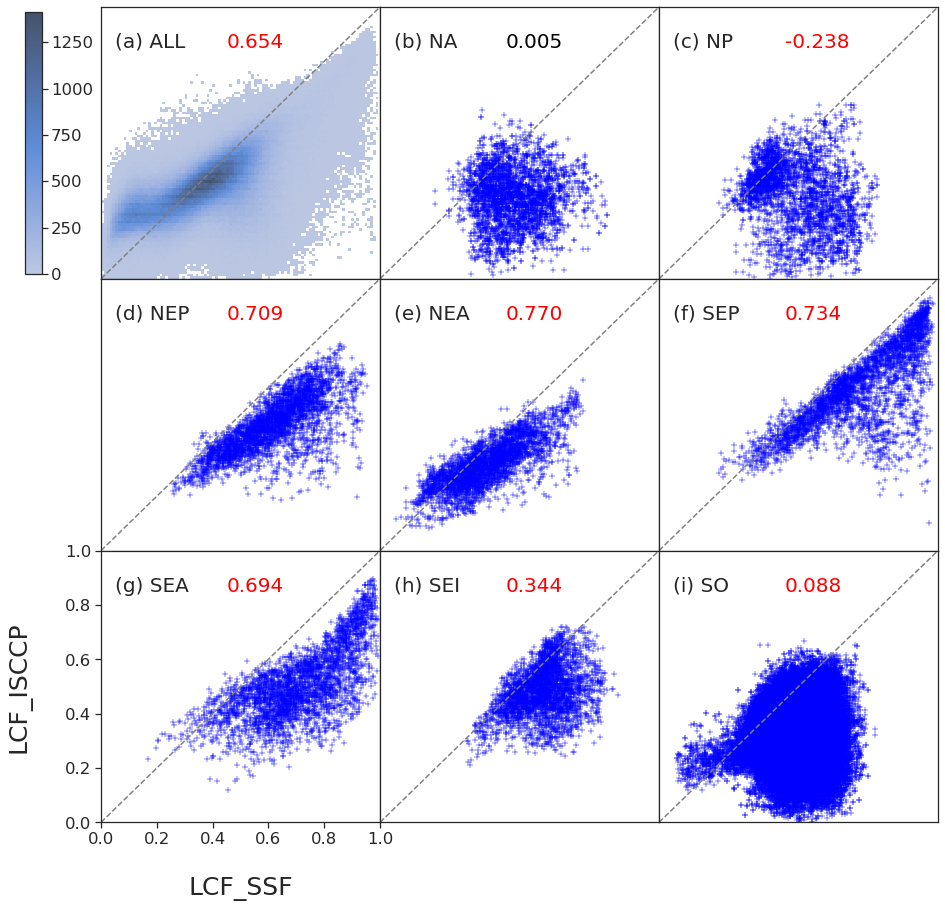

In [7]:
custom_params = {"axes.spines.right": True, "axes.spines.top": True}
sns.set_theme(style="ticks", rc=custom_params, font_scale = 1.5)

fig, axes = plt.subplots(3, 3, figsize=[15, 15])

ti= ['('+s+')' for s in 'abcdefghijkl']
for i, ax in enumerate(axes.flat):
    
      if i == 0:
          g = sns.histplot(x=df_new.LCF_CERES.values, y=df_new.LCF_ISCCP.values,
                           bins=100,
#                           stat='probability',
                           common_norm=False,
                           cbar=False,
                           ax=ax)
      else:      
          sns.scatterplot(x='LCF_CERES', y='LCF_ISCCP',
                          color='blue',
                          marker="+",
                          ax=ax,
                          data = plt_dat[i-1],
                         )
      ax.plot([0,1], [0,1], c='grey', linestyle='dashed') 
    
      ax.set_xlim([0,1.0])
      ax.set_ylim([0,1.0])
      ax.set_xlabel('LCF_SSF', fontsize=25) if i==6 else ax.set_xlabel('')
      ax.set_ylabel('LCF_ISCCP', fontsize=25) if i==6 else ax.set_ylabel('')
      ax.get_xaxis().set_ticks([0,0.2,0.4,0.6,0.8,1.0]) if i==6 else ax.get_xaxis().set_ticks([])
      ax.get_xaxis().set_ticks([0,0.2,0.4,0.6,0.8,1.0]) if i==6 else ax.get_yaxis().set_ticks([])
        
      if i == 0:
        ax.annotate(ti[i] + ' ' + 'ALL', xy=(0.05, 0.85), xycoords='axes fraction', fontsize=20)
        ax.annotate('{0:.3f}'.format(r0), xy=(0.45, 0.85), xycoords='axes fraction', fontsize=20, 
                    c='red' if p0 <= 0.05 else 'black')
      else:
        ax.annotate(ti[i] + ' ' + names[i-1], xy=(0.05, 0.85), xycoords='axes fraction', fontsize=20)
        ax.annotate('{0:.3f}'.format(r[i-1]), xy=(0.45, 0.85), xycoords='axes fraction', fontsize=20, 
                    c='red' if p[i-1] <= 0.05 else 'black')

axes[2,0].get_xaxis().set_label_coords(0.5, -0.2)
axes[2,0].get_yaxis().set_label_coords(-0.25, 0.5)

pos1 = axes[0,0].get_position()
x0   = pos1.x0
y0   = pos1.y0
hgt  = pos1.height
wth  = pos1.width

cb_ax = fig.add_axes([x0-0.07, y0-0.025, 0.015, hgt+0.02])
fig.colorbar(axes[0,0].get_children()[0], cax=cb_ax, orientation="vertical")

plt.subplots_adjust(hspace=0.0, wspace=0.0)
plt.show()


